# AirBnB data cleaning

## Notebook set-up

Assume we are preparing this data for a linear regression model.

In [1]:
# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor

import gperdrizet_functions as funcs

pd.set_option('display.max_rows', 500)

## 1. Data loading

In [2]:
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv')
data_df.head().transpose()

,0,1,2,3,4
id,2539,2595,3647,3831,5022
name,Clean & quiet apt home by the park,Skylit Midtown Castle,THE VILLAGE OF HARLEM....NEW YORK !,Cozy Entire Floor of Brownstone,Entire Apt: Spacious Studio/Loft by central park
host_id,2787,2845,4632,4869,7192
host_name,John,Jennifer,Elisabeth,LisaRoxanne,Laura
neighbourhood_group,Brooklyn,Manhattan,Manhattan,Brooklyn,Manhattan
neighbourhood,Kensington,Midtown,Harlem,Clinton Hill,East Harlem
latitude,40.64749,40.75362,40.80902,40.68514,40.79851
longitude,-73.97237,-73.98377,-73.9419,-73.95976,-73.94399
room_type,Private room,Entire home/apt,Private room,Entire home/apt,Entire home/apt
price,149,225,150,89,80


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

## 2. Feature selection

In [4]:
label='price'

features=[
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365',
    'neighbourhood_group',
    'room_type'
]

numerical_features=[
    'price',
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

nominal_features=['neighbourhood_group','room_type']

data_df=data_df[numerical_features + nominal_features].copy()

## 3. Feature encoding

In [5]:
encoded_datasets={}

### 3.1. Label encoding

In [6]:
label_encoded_data_df=data_df.copy()

for feature in nominal_features:
    label_encoder=LabelEncoder()
    label_encoded_data_df[feature]=label_encoder.fit_transform(label_encoded_data_df[feature])

encoded_datasets['Label encoded']=label_encoded_data_df
label_encoded_data_df[nominal_features].head()

,neighbourhood_group,room_type
0,1,1
1,2,0
2,2,1
3,1,0
4,2,0


### 3.2. One-hot encoding

In [7]:
one_hot_encoder=OneHotEncoder(sparse_output=False)
one_hot_encoded_data=one_hot_encoder.fit_transform(data_df[nominal_features])
one_hot_features=one_hot_encoder.get_feature_names_out()
one_hot_encoded_data_df=pd.DataFrame(one_hot_encoded_data, columns=one_hot_features)
one_hot_encoded_data_df=pd.concat([one_hot_encoded_data_df, data_df[numerical_features]], axis=1)
encoded_datasets['One-hot encoded']=one_hot_encoded_data_df
one_hot_encoded_data_df[one_hot_features].head()

,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### 3.3. Results

#### 3.3.1. Linear model

In [8]:
linear_cross_val_results_df, linear_tukey_result=funcs.evaluate_datasets(
    LinearRegression(),
    encoded_datasets
)

ANOVA p-value: 0.093



#### 3.3.2. Tree model

In [9]:
tree_cross_val_results_df, tree_tukey_result=funcs.evaluate_datasets(
    HistGradientBoostingRegressor(random_state=315),
    encoded_datasets
)

ANOVA p-value: 0.885



#### 3.3.3. Model comparison

Linear model:

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------
Label encoded One-hot encoded   0.0121 0.0926 -0.0021 0.0263  False
-------------------------------------------------------------------

Tree model:

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------
Label encoded One-hot encoded  -0.0012 0.8851 -0.0172 0.0149  False
-------------------------------------------------------------------


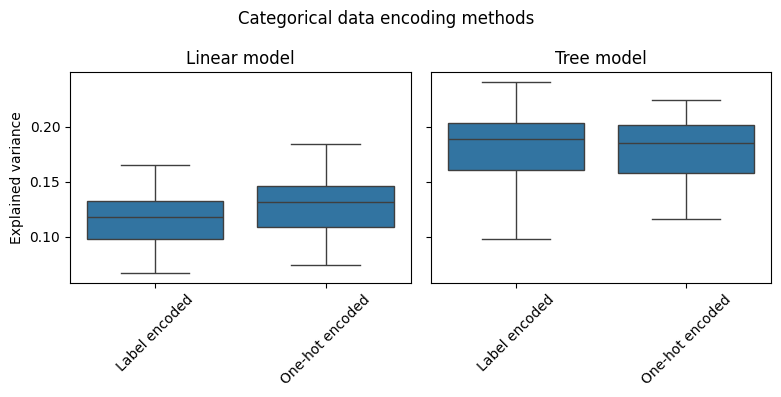

In [10]:
print(f'Linear model:\n\n{linear_tukey_result}\n')
print(f'Tree model:\n\n{tree_tukey_result}')

fig, axs=plt.subplots(1,2, figsize=(8,4), sharey=True)
axs=axs.flatten()

fig.suptitle('Categorical data encoding methods')

sns.boxplot(linear_cross_val_results_df, x='Feature set', y='Score', ax=axs[0])
axs[0].set_title('Linear model')
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_ylabel('Explained variance')

sns.boxplot(tree_cross_val_results_df, x='Feature set', y='Score', ax=axs[1])
axs[1].set_title('Tree model')
axs[1].set_xlabel('')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_ylabel('Explained variance')

plt.tight_layout()
plt.show()

## 4. Missing data

In [11]:
nan_cleaned_datasets={}
encoded_data_df=one_hot_encoded_data_df.copy()
encoded_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   neighbourhood_group_Bronx          48895 non-null  float64
 1   neighbourhood_group_Brooklyn       48895 non-null  float64
 2   neighbourhood_group_Manhattan      48895 non-null  float64
 3   neighbourhood_group_Queens         48895 non-null  float64
 4   neighbourhood_group_Staten Island  48895 non-null  float64
 5   room_type_Entire home/apt          48895 non-null  float64
 6   room_type_Private room             48895 non-null  float64
 7   room_type_Shared room              48895 non-null  float64
 8   price                              48895 non-null  int64  
 9   latitude                           48895 non-null  float64
 10  longitude                          48895 non-null  float64
 11  minimum_nights                     48895 non-null  int

### 4.1. Drop reviews per month

In [12]:
nan_cleaned_datasets['-reviews_per_month']=encoded_data_df.drop('reviews_per_month', axis=1).dropna()

### 4.2. Drop NAN rows

In [13]:
nan_cleaned_datasets['Dropped']=encoded_data_df.dropna()
print(f"Reviews per month mean: {nan_cleaned_datasets['Dropped']['reviews_per_month'].mean():.2f}")

Reviews per month mean: 1.37


### 4.2. Fill NAN with median

In [14]:
median_imputer=SimpleImputer(strategy='median')
median_imputed_data=median_imputer.fit_transform(encoded_data_df)
nan_cleaned_datasets['Median imputed']=pd.DataFrame(median_imputed_data, columns=encoded_data_df.columns)
print(f"Reviews per month mean: {nan_cleaned_datasets['Median imputed']['reviews_per_month'].mean():.2f}")

Reviews per month mean: 1.24


### 4.3. KNN imputation

In [15]:
knn_imputer=KNNImputer()
knn_imputed_data=knn_imputer.fit_transform(encoded_data_df)
nan_cleaned_datasets['KNN imputed']=pd.DataFrame(knn_imputed_data, columns=encoded_data_df.columns)
print(f"Reviews per month mean: {nan_cleaned_datasets['KNN imputed']['reviews_per_month'].mean():.2f}")

Reviews per month mean: 1.18


### 4.3. Results

#### 4.3.1. Reviews per month distributions

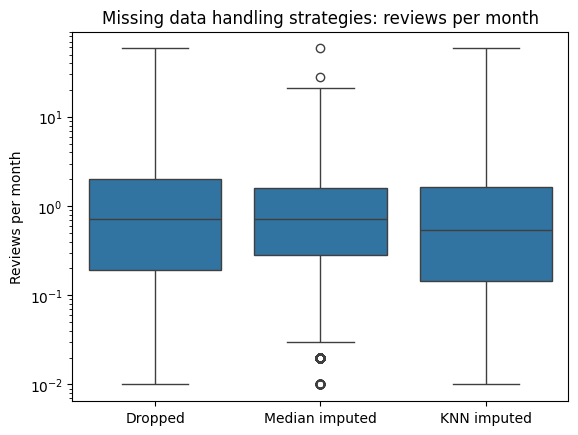

In [16]:
strategy=['Dropped']*len(nan_cleaned_datasets['Dropped']['reviews_per_month']) + ['Median imputed']*len(nan_cleaned_datasets['Median imputed']['reviews_per_month']) + ['KNN imputed']*len(nan_cleaned_datasets['KNN imputed']['reviews_per_month'])
reviews_per_month=nan_cleaned_datasets['Dropped']['reviews_per_month'].to_list() + nan_cleaned_datasets['Median imputed']['reviews_per_month'].to_list() + nan_cleaned_datasets['KNN imputed']['reviews_per_month'].to_list()

reviews_per_month_df=pd.DataFrame.from_dict(
    {
        'Strategy':strategy,
        'Reviews per month':reviews_per_month
    }
)

sns.boxplot(reviews_per_month_df, x='Strategy', y='Reviews per month', log_scale=True)
plt.title('Missing data handling strategies: reviews per month')
plt.xlabel('')
plt.show()

#### 4.3.2. Linear model

In [17]:
linear_cross_val_results_df, linear_tukey_result=funcs.evaluate_datasets(
    LinearRegression(),
    nan_cleaned_datasets
)

ANOVA p-value: 0.000



#### 4.3.3. Tree model

In [18]:
tree_cross_val_results_df, tree_tukey_result=funcs.evaluate_datasets(
    HistGradientBoostingRegressor(),
    nan_cleaned_datasets
)

ANOVA p-value: 0.000



#### 4.3.4. Model comparison

Linear model:

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
      group1           group2     meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
-reviews_per_month        Dropped   0.0268 0.0002  0.0108  0.0428   True
-reviews_per_month    KNN imputed      0.0    1.0  -0.016   0.016  False
-reviews_per_month Median imputed     -0.0    1.0 -0.0161   0.016  False
           Dropped    KNN imputed  -0.0268 0.0002 -0.0428 -0.0107   True
           Dropped Median imputed  -0.0268 0.0002 -0.0428 -0.0108   True
       KNN imputed Median imputed  -0.0001    1.0 -0.0161   0.016  False
------------------------------------------------------------------------

Tree model:

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
      group1           group2     meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
-reviews_per_month    

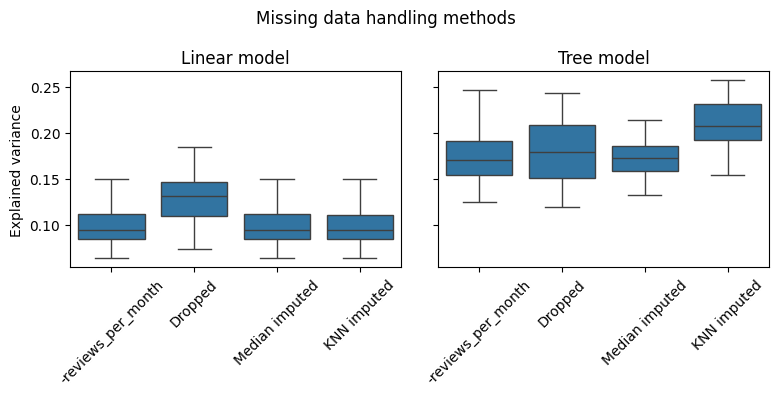

In [19]:
print(f'Linear model:\n\n{linear_tukey_result}\n')
print(f'Tree model:\n\n{tree_tukey_result}')

fig, axs=plt.subplots(1,2, figsize=(8,4), sharey=True)
axs=axs.flatten()

fig.suptitle('Missing data handling methods')

sns.boxplot(linear_cross_val_results_df, x='Feature set', y='Score', ax=axs[0])
axs[0].set_title('Linear model')
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_ylabel('Explained variance')

sns.boxplot(tree_cross_val_results_df, x='Feature set', y='Score', ax=axs[1])
axs[1].set_title('Tree model')
axs[1].set_xlabel('')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_ylabel('Explained variance')

plt.tight_layout()
plt.show()

## 5. Extreme values

In [37]:
cleaned_datasets={}
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv')
data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,48895.0,1.901714e+07,1.098311e+07,2539.00000,9.471945e+06,1.967728e+07,2.915218e+07,3.648724e+07
host_id,48895.0,6.762001e+07,7.861097e+07,2438.00000,7.822033e+06,3.079382e+07,1.074344e+08,2.743213e+08
latitude,48895.0,4.072895e+01,5.453008e-02,40.49979,4.069010e+01,4.072307e+01,4.076311e+01,4.091306e+01
longitude,48895.0,-7.395217e+01,4.615674e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48895.0,1.527207e+02,2.401542e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48895.0,7.029962e+00,2.051055e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48895.0,2.327447e+01,4.455058e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38843.0,1.373221e+00,1.680442e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48895.0,7.143982e+00,3.295252e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48895.0,1.127813e+02,1.316223e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


### 5.1. Remove errors/placeholders in minimum nights

In [38]:
data_df=data_df[data_df['minimum_nights'] < 999]
data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,48890.0,1.901771e+07,1.098299e+07,2539.00000,9.472371e+06,1.967743e+07,2.915225e+07,3.648724e+07
host_id,48890.0,6.761919e+07,7.861043e+07,2438.00000,7.822737e+06,3.079553e+07,1.074344e+08,2.743213e+08
latitude,48890.0,4.072895e+01,5.453090e-02,40.49979,4.069009e+01,4.072307e+01,4.076312e+01,4.091306e+01
longitude,48890.0,-7.395217e+01,4.615721e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48890.0,1.527186e+02,2.401634e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48890.0,6.923359e+00,1.756595e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,5.000000e+02
number_of_reviews,48890.0,2.327627e+01,4.455240e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38840.0,1.373296e+00,1.680480e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48890.0,7.144508e+00,3.295416e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48890.0,1.127646e+02,1.316125e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


### 5.1. Clean hosts

In [39]:
institutional_hosts=['Blueground','Sonder (NYC)','Sonder', 'Row NYC', 'Corporate Housing']

hosts_cleaned_df=data_df.copy()
hosts_cleaned_df=data_df[~data_df['host_name'].isin(institutional_hosts)]
cleaned_datasets['Hosts cleaned']=hosts_cleaned_df[numerical_features + nominal_features].copy()

hosts_cleaned_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,48135.0,1.884799e+07,1.096038e+07,2539.00000,9.365151e+06,1.943962e+07,2.887675e+07,3.648724e+07
host_id,48135.0,6.648455e+07,7.809496e+07,2438.00000,7.601465e+06,3.028359e+07,1.050619e+08,2.743213e+08
latitude,48135.0,4.072889e+01,5.487038e-02,40.49979,4.068966e+01,4.072295e+01,4.076346e+01,4.091306e+01
longitude,48135.0,-7.395151e+01,4.617027e-02,-74.24442,-7.398239e+01,-7.395517e+01,-7.393560e+01,-7.371299e+01
price,48135.0,1.511931e+02,2.414060e+02,0.00000,6.900000e+01,1.040000e+02,1.750000e+02,1.000000e+04
minimum_nights,48135.0,6.670967e+00,1.749395e+01,1.00000,1.000000e+00,2.000000e+00,5.000000e+00,5.000000e+02
number_of_reviews,48135.0,2.359825e+01,4.481607e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38491.0,1.371585e+00,1.652288e+00,0.01000,1.900000e-01,7.100000e-01,2.020000e+00,2.094000e+01
calculated_host_listings_count,48135.0,3.551761e+00,1.106067e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,1.210000e+02
availability_365,48135.0,1.101981e+02,1.305636e+02,0.00000,0.000000e+00,4.100000e+01,2.180000e+02,3.650000e+02


### 5.2. Clip price

In [40]:
price_clipped_df=data_df.copy()
price_clipped_df['price']=price_clipped_df['price'].clip(upper=5000)
cleaned_datasets['Price clipped']=price_clipped_df[numerical_features + nominal_features].copy()
price_clipped_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,48890.0,1.901771e+07,1.098299e+07,2539.00000,9.472371e+06,1.967743e+07,2.915225e+07,3.648724e+07
host_id,48890.0,6.761919e+07,7.861043e+07,2438.00000,7.822737e+06,3.079553e+07,1.074344e+08,2.743213e+08
latitude,48890.0,4.072895e+01,5.453090e-02,40.49979,4.069009e+01,4.072307e+01,4.076312e+01,4.091306e+01
longitude,48890.0,-7.395217e+01,4.615721e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48890.0,1.516085e+02,2.066895e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,5.000000e+03
minimum_nights,48890.0,6.923359e+00,1.756595e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,5.000000e+02
number_of_reviews,48890.0,2.327627e+01,4.455240e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38840.0,1.373296e+00,1.680480e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48890.0,7.144508e+00,3.295416e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48890.0,1.127646e+02,1.316125e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


### 5.3. Clip price and clean hosts

In [41]:
price_clipped_host_cleaned_df=data_df.copy()
price_clipped_host_cleaned_df['price']=price_clipped_host_cleaned_df['price'].clip(upper=5000)
price_clipped_host_cleaned_df=price_clipped_host_cleaned_df[~price_clipped_host_cleaned_df['host_name'].isin(institutional_hosts)]
cleaned_datasets['Hosts cleaned, price clipped']=price_clipped_host_cleaned_df[numerical_features + nominal_features].copy()
price_clipped_host_cleaned_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,48135.0,1.884799e+07,1.096038e+07,2539.00000,9.365151e+06,1.943962e+07,2.887675e+07,3.648724e+07
host_id,48135.0,6.648455e+07,7.809496e+07,2438.00000,7.601465e+06,3.028359e+07,1.050619e+08,2.743213e+08
latitude,48135.0,4.072889e+01,5.487038e-02,40.49979,4.068966e+01,4.072295e+01,4.076346e+01,4.091306e+01
longitude,48135.0,-7.395151e+01,4.617027e-02,-74.24442,-7.398239e+01,-7.395517e+01,-7.393560e+01,-7.371299e+01
price,48135.0,1.500657e+02,2.075593e+02,0.00000,6.900000e+01,1.040000e+02,1.750000e+02,5.000000e+03
minimum_nights,48135.0,6.670967e+00,1.749395e+01,1.00000,1.000000e+00,2.000000e+00,5.000000e+00,5.000000e+02
number_of_reviews,48135.0,2.359825e+01,4.481607e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38491.0,1.371585e+00,1.652288e+00,0.01000,1.900000e-01,7.100000e-01,2.020000e+00,2.094000e+01
calculated_host_listings_count,48135.0,3.551761e+00,1.106067e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,1.210000e+02
availability_365,48135.0,1.101981e+02,1.305636e+02,0.00000,0.000000e+00,4.100000e+01,2.180000e+02,3.650000e+02


### 5.4. Encode and impute cleaned datasets

In [42]:
for dataset, data_df in cleaned_datasets.items():

    for feature in nominal_features:
        label_encoder=LabelEncoder()
        data_df[feature]=label_encoder.fit_transform(data_df[feature].copy())

    knn_imputer=KNNImputer()
    data_df[numerical_features]=knn_imputer.fit_transform(data_df[numerical_features].copy())
    cleaned_datasets[dataset]=data_df

cleaned_datasets['Raw']=nan_cleaned_datasets['KNN imputed']

### 5.5. Results

#### 5.5.1. Linear model

In [43]:
linear_cross_val_results_df, linear_tukey_result=funcs.evaluate_datasets(
    LinearRegression(),
    cleaned_datasets
)

ANOVA p-value: 0.000



#### 5.5.2. Tree model

In [44]:
tree_cross_val_results_df, tree_tukey_result=funcs.evaluate_datasets(
    HistGradientBoostingRegressor(),
    cleaned_datasets
)

ANOVA p-value: 0.000



#### 5.5.3. Model comparison

Linear model:

                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                       
           group1                       group2            meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------
               Hosts cleaned Hosts cleaned, price clipped   0.0261    0.0  0.0157  0.0364   True
               Hosts cleaned                Price clipped   0.0302    0.0  0.0198  0.0406   True
               Hosts cleaned                          Raw   0.0113 0.0266   0.001  0.0217   True
Hosts cleaned, price clipped                Price clipped   0.0042 0.7242 -0.0062  0.0146  False
Hosts cleaned, price clipped                          Raw  -0.0147 0.0019 -0.0251 -0.0043   True
               Price clipped                          Raw  -0.0189    0.0 -0.0293 -0.0085   True
------------------------------------------------------------------------------------------------

Tree model:

 

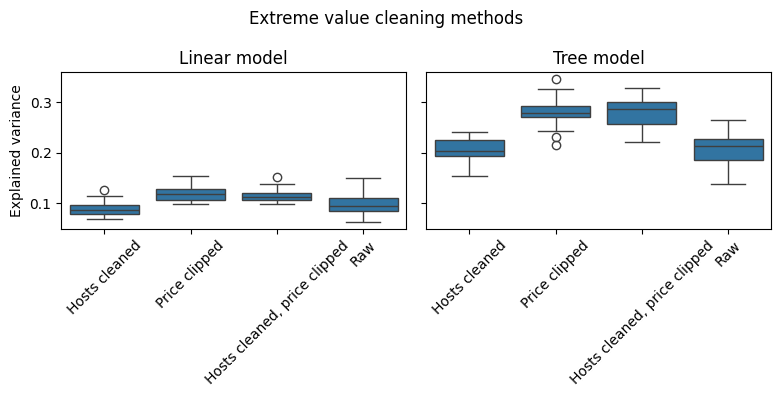

In [45]:
print(f'Linear model:\n\n{linear_tukey_result}\n')
print(f'Tree model:\n\n{tree_tukey_result}')

fig, axs=plt.subplots(1,2, figsize=(8,4), sharey=True)
axs=axs.flatten()

fig.suptitle('Extreme value cleaning methods')

sns.boxplot(linear_cross_val_results_df, x='Feature set', y='Score', ax=axs[0])
axs[0].set_title('Linear model')
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_ylabel('Explained variance')

sns.boxplot(tree_cross_val_results_df, x='Feature set', y='Score', ax=axs[1])
axs[1].set_title('Tree model')
axs[1].set_xlabel('')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_ylabel('Explained variance')

plt.tight_layout()
plt.show()

## 6. Save cleaned data

### 6. Take a final look at the feature distributions

In [46]:
cleaned_datasets['Hosts cleaned, price clipped'].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,48135.0,150.065669,207.559298,0.00000,69.00000,104.00000,175.000000,5000.00000
latitude,48135.0,40.728892,0.054870,40.49979,40.68966,40.72295,40.763455,40.91306
longitude,48135.0,-73.951507,0.046170,-74.24442,-73.98239,-73.95517,-73.935605,-73.71299
minimum_nights,48135.0,6.670967,17.493950,1.00000,1.00000,2.00000,5.000000,500.00000
number_of_reviews,48135.0,23.598255,44.816070,0.00000,1.00000,5.00000,24.000000,629.00000
reviews_per_month,48135.0,1.178454,1.543982,0.01000,0.14000,0.53600,1.660000,20.94000
calculated_host_listings_count,48135.0,3.551761,11.060666,1.00000,1.00000,1.00000,2.000000,121.00000
availability_365,48135.0,110.198089,130.563590,0.00000,0.00000,41.00000,218.000000,365.00000
neighbourhood_group,48135.0,1.670281,0.740447,0.00000,1.00000,2.00000,2.000000,4.00000
room_type,48135.0,0.511603,0.545919,0.00000,0.00000,0.00000,1.000000,2.00000


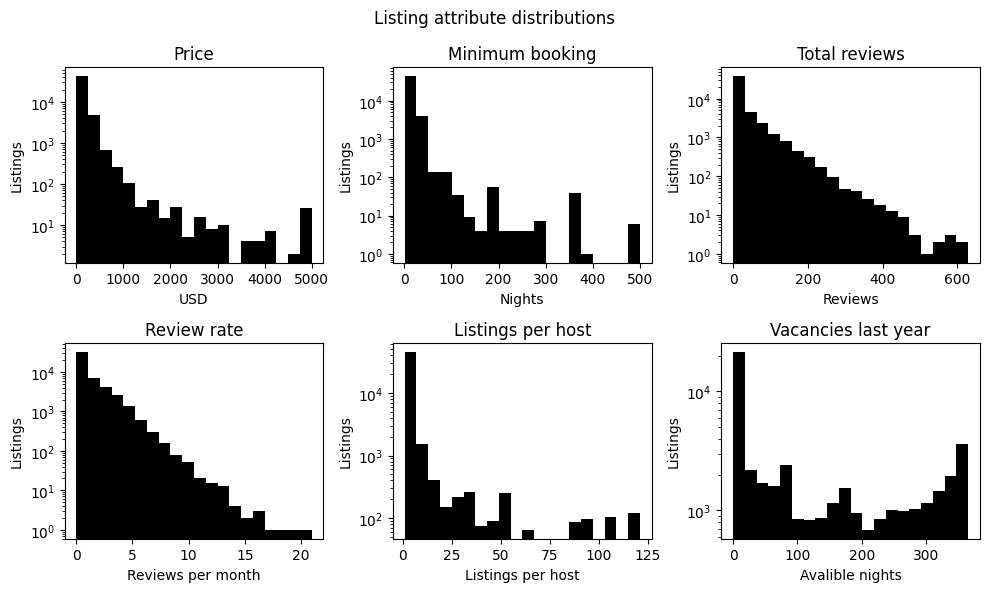

In [47]:
features=['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
plot_titles=['Price', 'Minimum booking', 'Total reviews', 'Review rate', 'Listings per host', 'Vacancies last year']
xlabels=['USD', 'Nights', 'Reviews', 'Reviews per month', 'Listings per host', 'Avalible nights']

fig, axs=plt.subplots(2,3, figsize=(10,6))
axs=axs.flatten()

fig.suptitle('Listing attribute distributions')

for i, (plot_title, feature, xlabel) in enumerate(zip(plot_titles, features, xlabels)):

    axs[i].set_title(plot_title)
    axs[i].hist(cleaned_datasets['Hosts cleaned, price clipped'][feature], bins=20, color='black')
    axs[i].set_xlabel(xlabel)
    axs[i].set_ylabel('Listings')
    axs[i].set_yscale('log')

plt.tight_layout()


#### 6.2. Write best dataset to disk

In [49]:
cleaned_datasets['Hosts cleaned, price clipped'].reset_index(drop=True).to_parquet('./data/processed/gperdrizet_cleaned_data.parquet')